In [1]:
%matplotlib inline

# Analyze Stereoseq whole brain tissue
This tutorial shows how to apply Bering to Stereoseq whole brain data.

Stereoseq whole brain {cite}`chen2022spatiotemporal` data was derived from: https://db.cngb.org/stomics/mosta/.
Stereoseq is a sequencing-based spatial transcriptomics technology which subcellular resolution. Here, we demonstrate the segmentation performance of Bering using E16.5 whole brain data.

### Import packages & data

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import Bering as br

In [3]:
# load data
df_spots_all = br.datasets.stereoseq_embryobrain_chen()
df_spots_seg = df_spots_all[df_spots_all['labels'] != 'background'] # foreground nodes
df_spots_unseg = df_spots_all[df_spots_all['labels'] == 'background'] # background nodes
img = None
channels = None

df_spots_seg.head()

,x,y,z,features,segmented,labels,region
index,,,,,,,
1803,9530,20996,0,Prox1,25200,Radial glia,Pall VZ
1804,9304,19163,0,Prox1,22492,Glutamatergic neuron,Die
1806,9962,19134,0,Prox1,29807,Glutamatergic neuron,Die
1807,8812,20901,0,Prox1,17831,Radial glia,Pall VZ
1809,10028,18697,0,Prox1,30784,Glutamatergic neuron,Die


In [4]:
df_spots_unseg.head() # visualize unsegmented data

,x,y,z,features,segmented,labels,region
index,,,,,,,
14481,11716,19119,0,Rgs4,-1,background,
16791,8174,18834,0,Atp1b1,-1,background,
44115,11972,21816,0,Cntnap5b,-1,background,
44122,9841,18894,0,Cntnap5b,-1,background,
44492,11608,21993,0,Cntnap5b,-1,background,


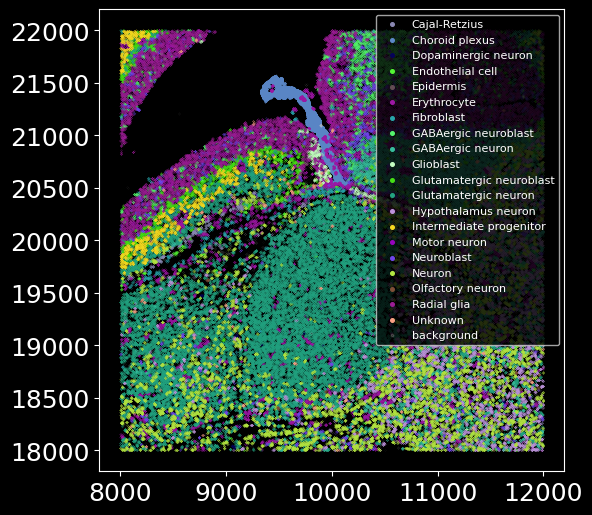

In [5]:
# visualize the spots
x, y = df_spots_seg['x'].values, df_spots_seg['y'].values
cell_types = df_spots_seg['labels'].values

fig, ax = plt.subplots(figsize = (6, 6))
for idx, cell_type in enumerate(np.unique(cell_types)):
    
    xc = x[np.where(cell_types == cell_type)[0]]
    yc = y[np.where(cell_types == cell_type)[0]]

    ax.scatter(xc, yc, s = 0.03, label = cell_type, color = np.random.rand(3,))

xb, yb = df_spots_unseg['x'].values, df_spots_unseg['y'].values
ax.scatter(xb, yb, color = '#DCDCDC', alpha = 0.2, s = 0.015, label = 'background')

h, l = ax.get_legend_handles_labels()
plt.legend(h, l, loc = 'upper right', fontsize = 8, markerscale = 15)

### Create Bering object

In [6]:
# image-dependent segmentation
bg = br.BrGraph(df_spots_seg, df_spots_unseg, img, channels)
bg

In [7]:
bg.segmented.head() # summary of cells

,cx,cy,cz,dx,dy,dz,d,labels
segmented,,,,,,,,
0,9525.0,20996.0,0.0,20,9,0,20,Radial glia
1,9299.0,19172.0,0.0,39,37,0,39,Glutamatergic neuron
2,9952.0,19127.0,0.0,23,27,0,27,Glutamatergic neuron
3,8819.5,20904.5,0.0,26,34,0,34,Radial glia
4,10031.0,18707.0,0.0,19,33,0,33,Glutamatergic neuron


### Create training data

In [8]:
# Build graphs for GCN training purpose
br.graphs.BuildWindowGraphs(
    bg, 
    n_cells_perClass = 40, 
    window_width = 40.0, 
    window_height = 40.0, 
    n_neighbors = 20, 
)

In [9]:
br.graphs.CreateData(
    bg, 
    batch_size = 16, 
    training_ratio = 0.8, 
)

### Training

Training node classifier:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [03:21<00:03,  3.12s/it]

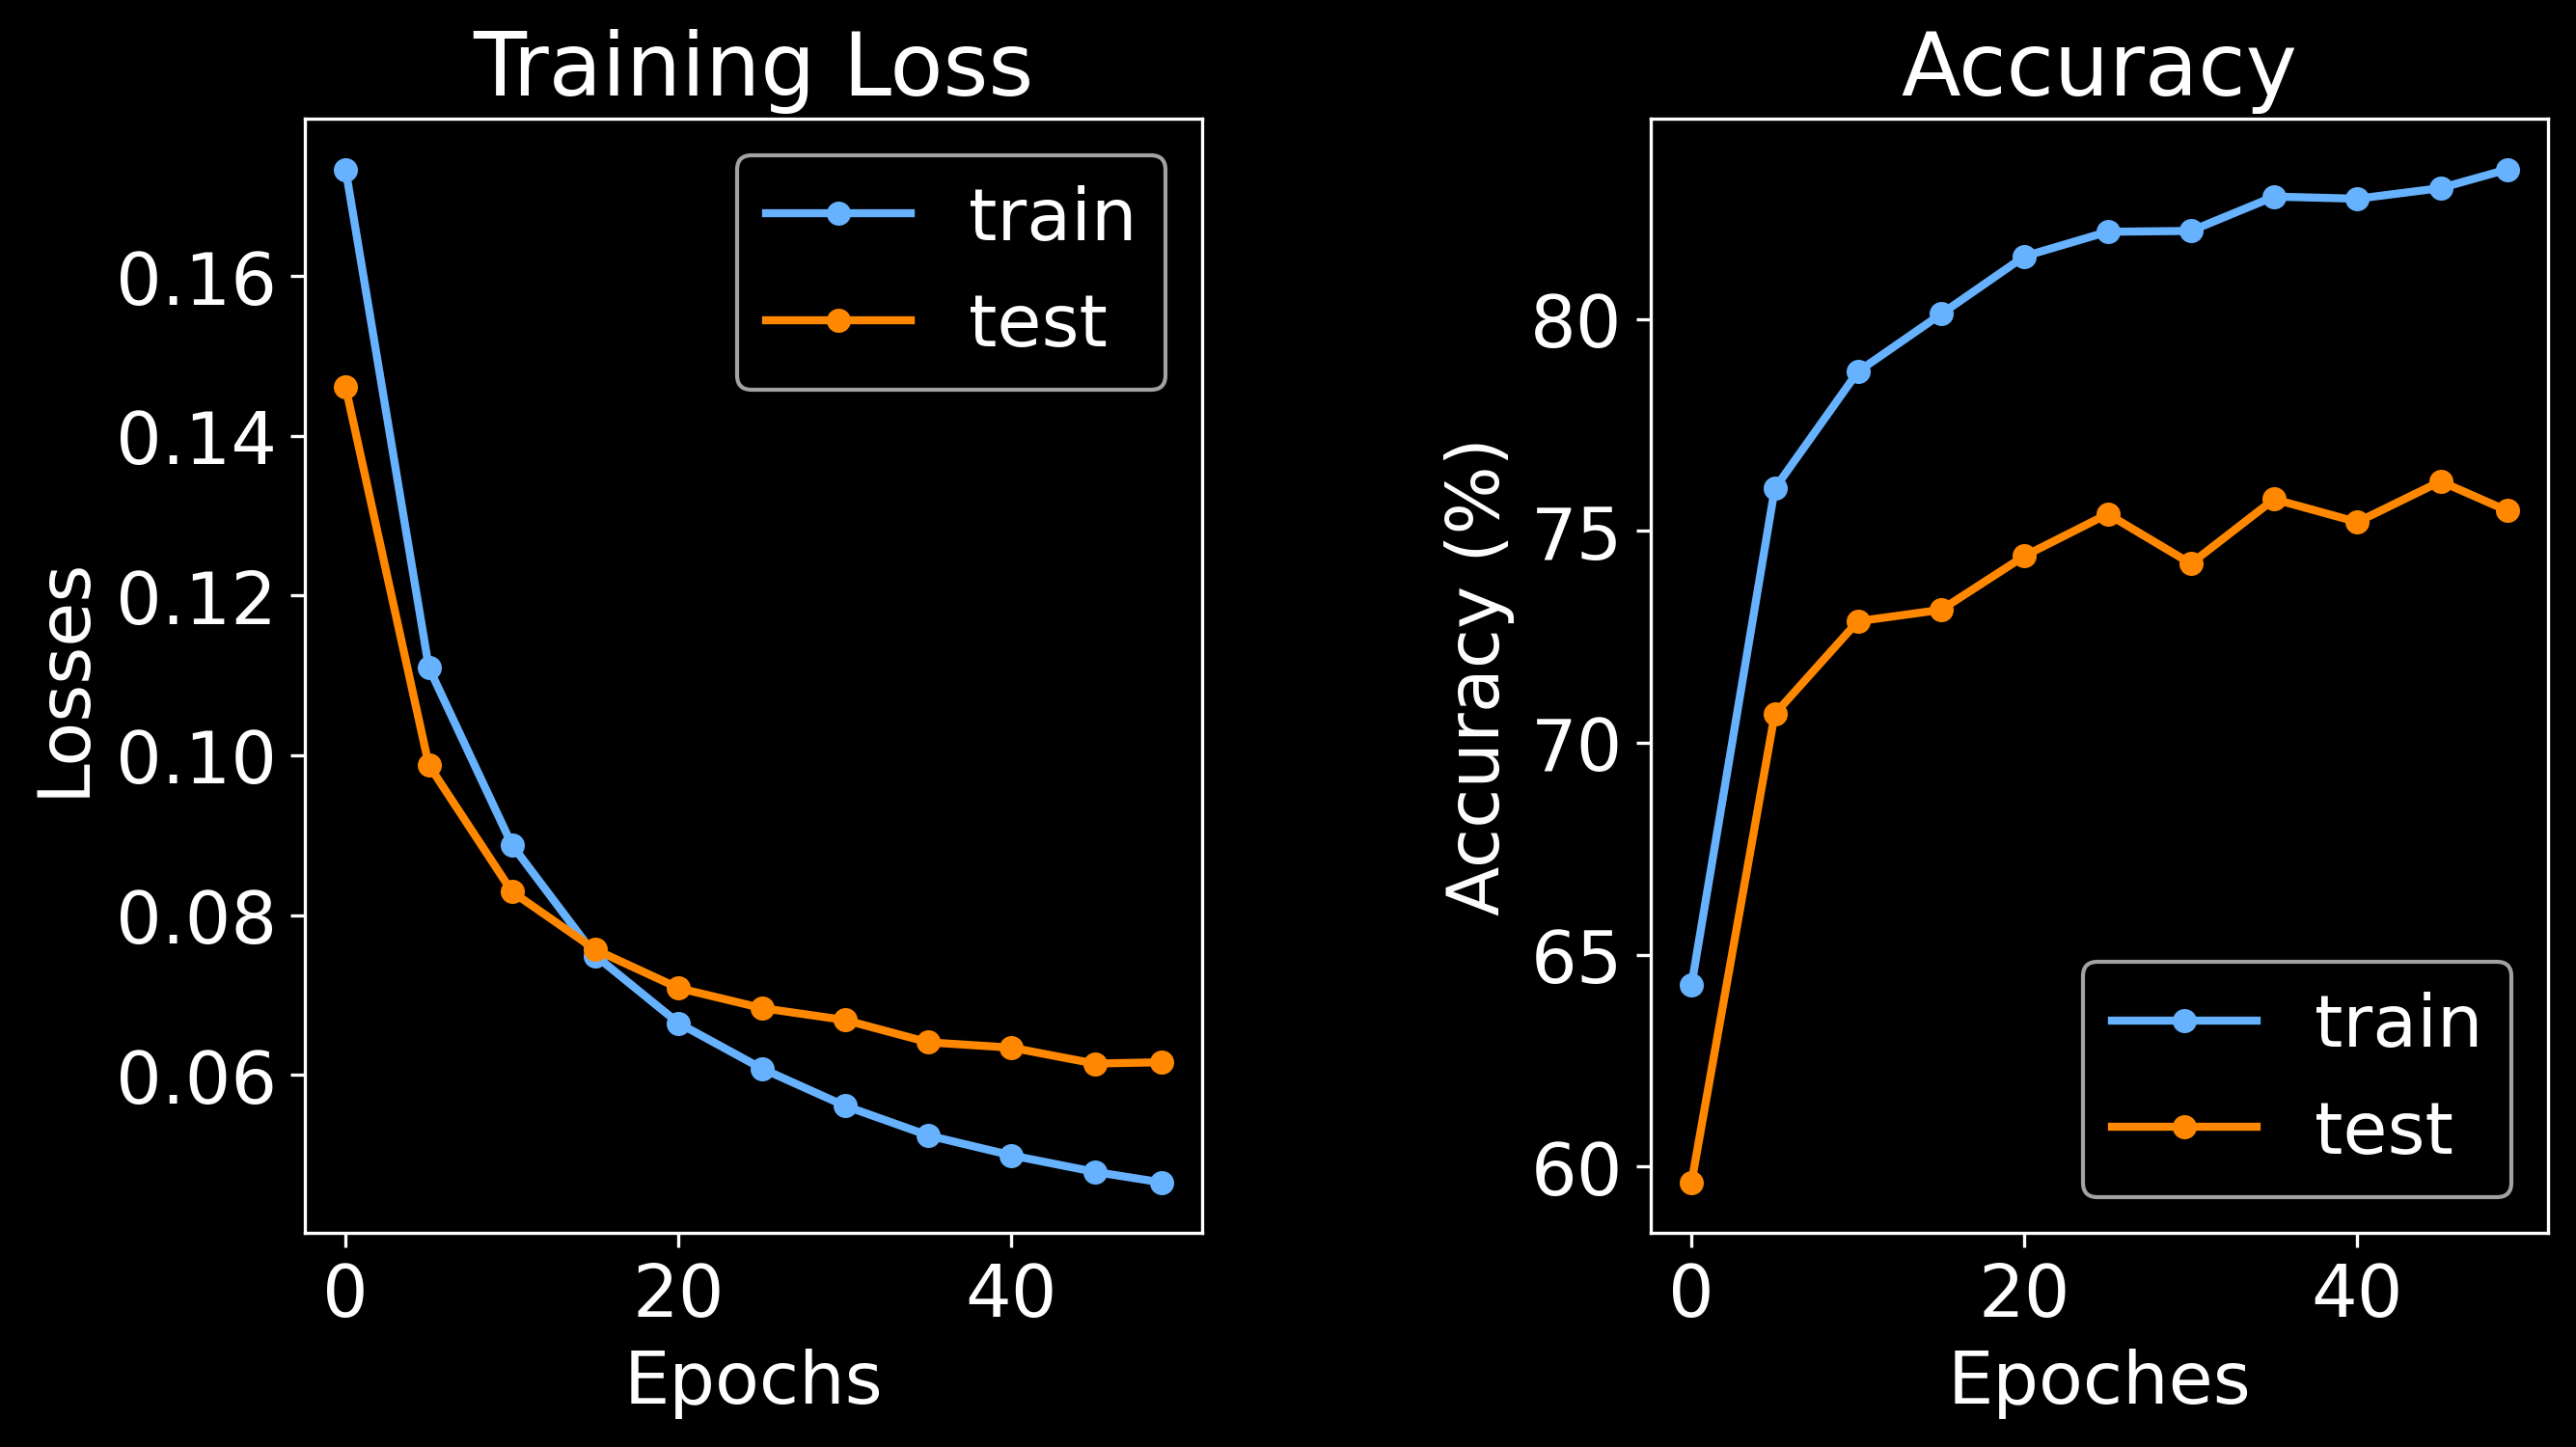

Training edge classifier:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [04:23<00:04,  4.93s/it]

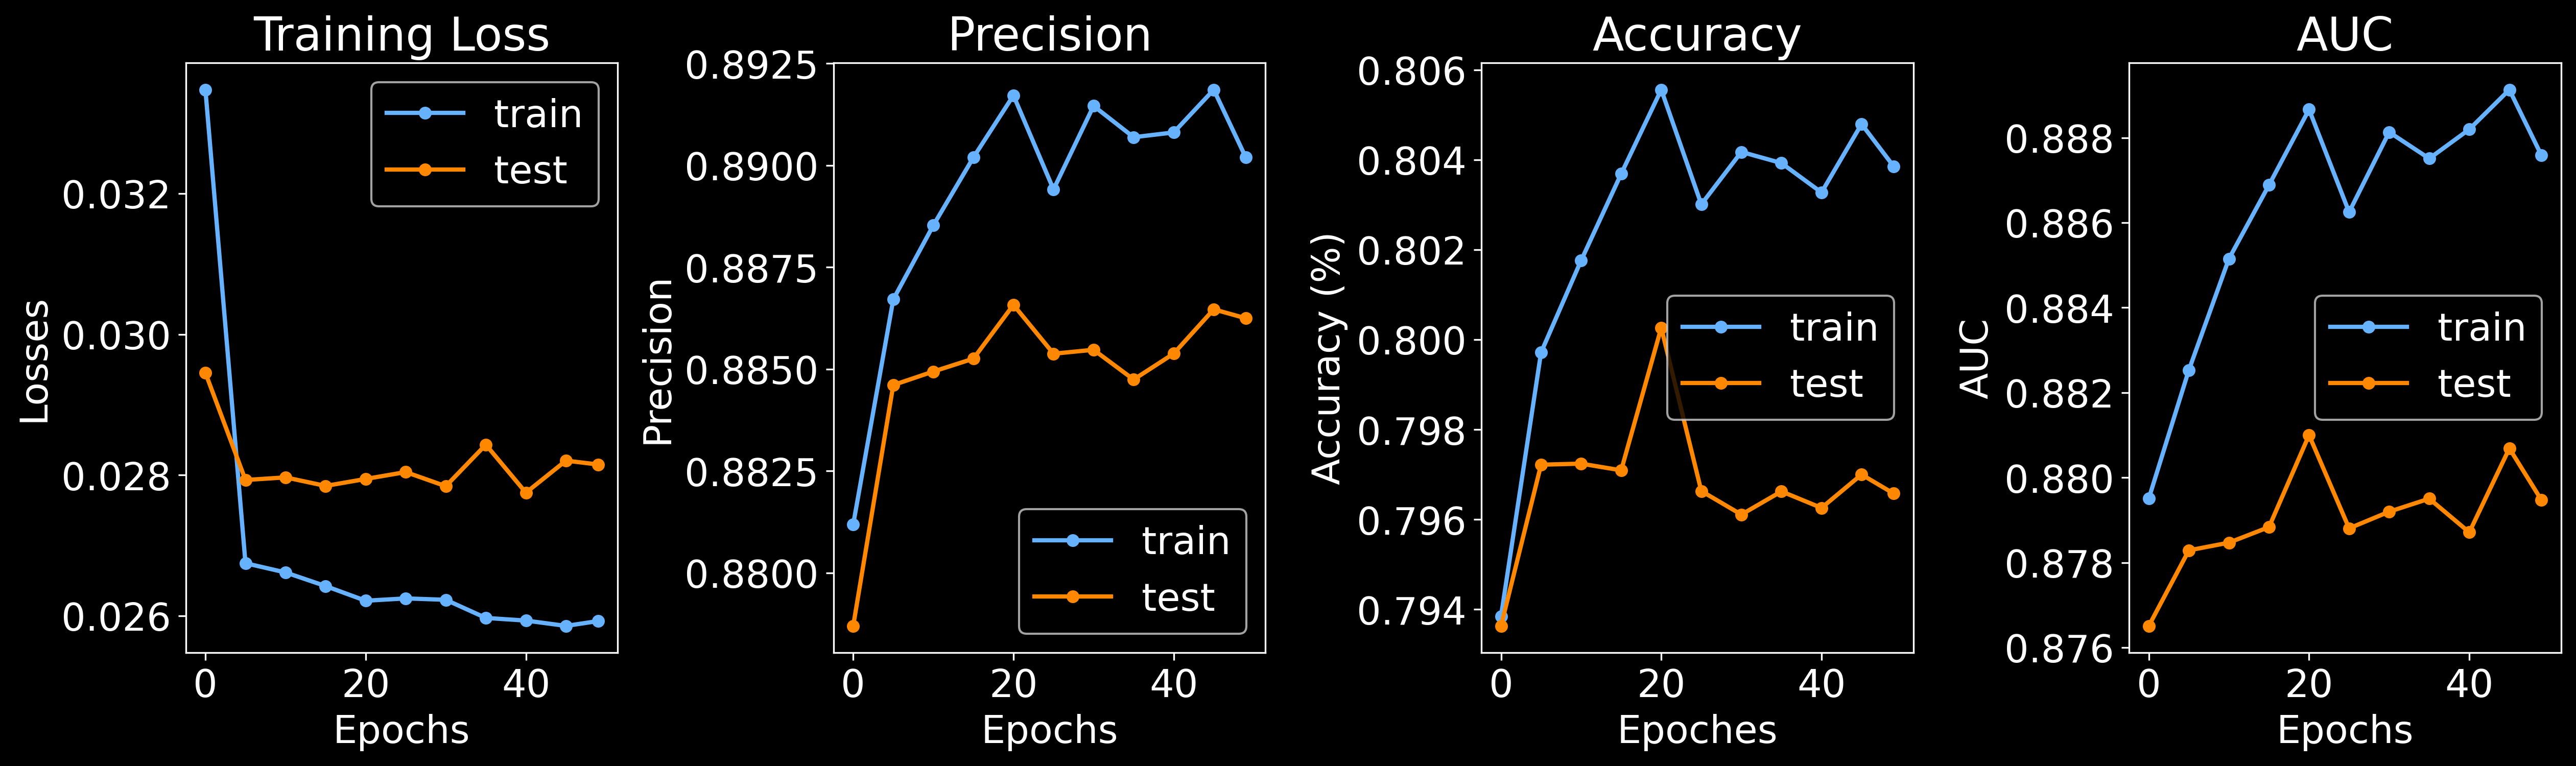

Training edge classifier: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:33<00:00,  5.48s/it]


In [10]:
br.train.Training(
    bg,
    edge_rbf_start = 0,
    edge_rbf_stop = 48,
    edge_rbf_n_kernels = 64,
)

In [11]:
# save the trained model
import pickle
with open('iss_ca1_qian.pkl', 'wb') as f:
    pickle.dump(bg, f)

### Visualizing model

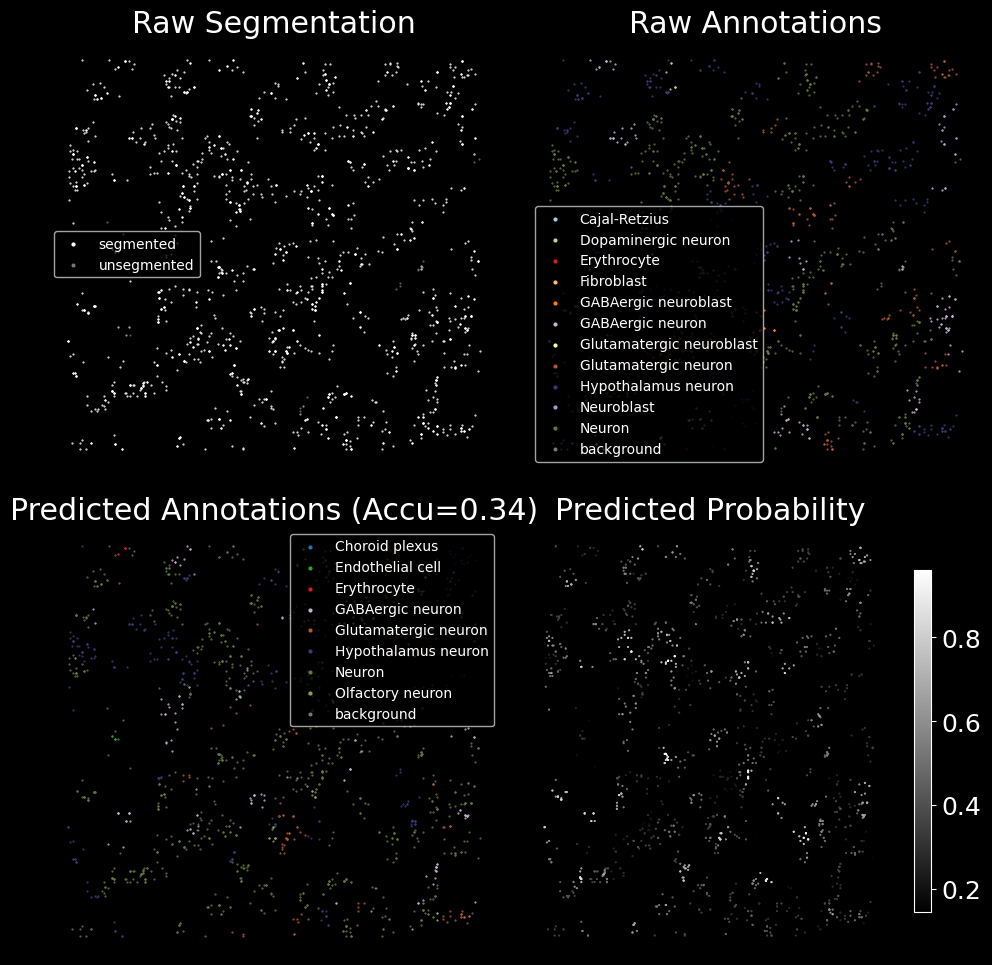

In [12]:
# randomly select a cell
random_cell = cells = random.sample(bg.segmented.index.values.tolist(), 1)[0]

# plot node classification
df_window_raw, df_window_pred, predictions = br.pl.Plot_Classification(
    bg, 
    cell_name = random_cell,
    n_neighbors = 10, 
    zoomout_scale = 8,
)

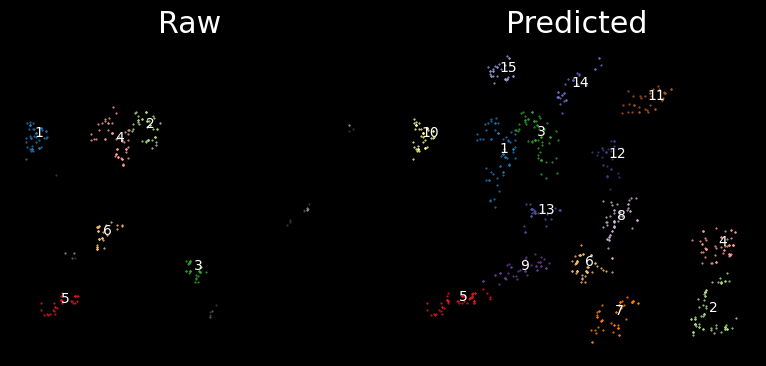

In [13]:
# plot cell segmentation
br.pl.Plot_Segmentation(
    bg, 
    cell_name = random_cell,
    df_window_raw = df_window_raw, 
    df_window_pred = df_window_pred,
    predictions = predictions,
    n_neighbors = 10, 
    zoomout_scale = 8,
    use_image = True,
    pos_thresh = 0.6,
    resolution = 0.05,
    num_edges_perSpot = 100,
    min_prob_nodeclf = 0.3,
    n_iters = 20,
)

After the model is trained, we can use the trained model to predict the cell types and segment all spots on the whole slice. After node classification and cell segmentation is completed, we generate single cell matrix in the end.

### Node classification
Conduct node classification on the whole slice.

In [14]:
br.tl.node_classification(
    bg, bg.spots_all.copy(), 
    n_neighbors = 20, 
)
bg.spots_all.to_csv('spots_all.txt', sep = '\t')

### Cell segmentation

In [15]:
br.tl.cell_segmentation(bg)

### Get single cells

In [16]:
df_results, adata_ensembl, adata_segmented = br.tl.cell_annotation(bg)
df_results.to_csv('results.txt', sep = '\t')
adata_ensembl.write('results_cells_ensembled.h5ad')
adata_segmented.write('results_cells_segmented.h5ad')

print(f'Ensembled anndata: {adata_ensembl.shape}')
print(f'Segmented anndata: {adata_segmented.shape}')

... storing 'predicted_labels' as categorical


Ensembled anndata: (1642, 223)
Segmented anndata: (7918, 223)


### Single cell data analysis

2023-08-22 17:52:36.256254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 17:52:37.332336: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


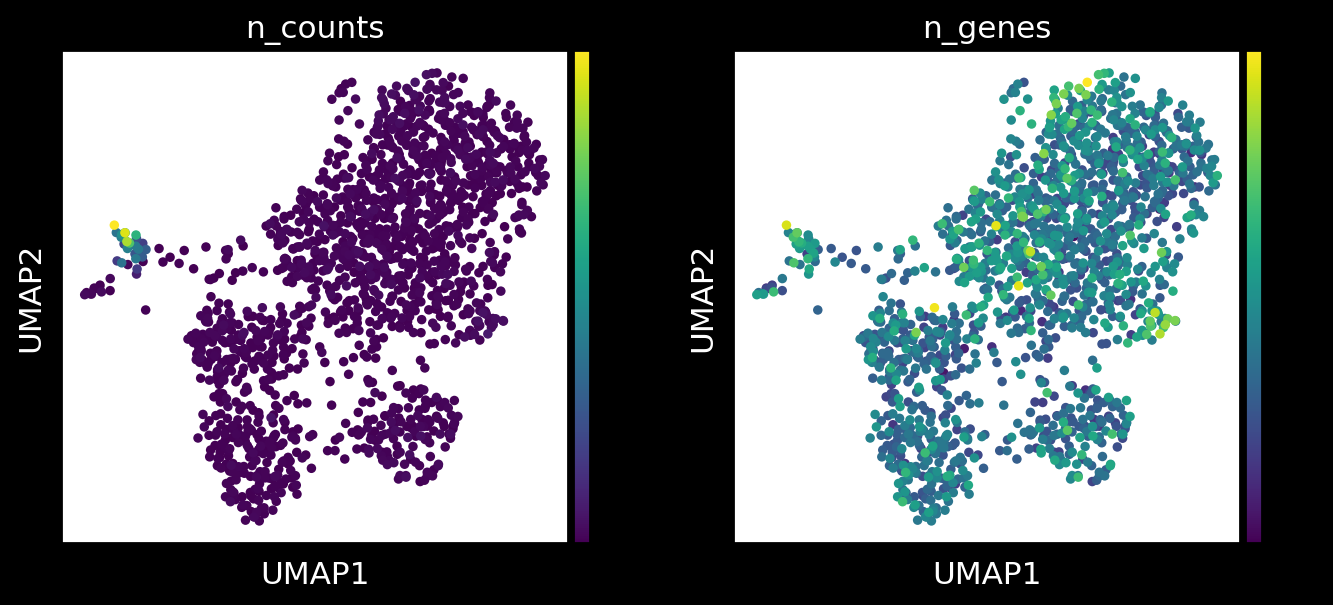

In [17]:
import scanpy as sc
sc.settings.set_figure_params(dpi=80)

# run standard analysis on the ensembled anndata
adata_ensembl = br.tl.cell_analyze(adata_ensembl, min_counts = 5)

# first check the data quality of segmented cells
sc.pl.umap(adata_ensembl, color = ['n_counts','n_genes'])

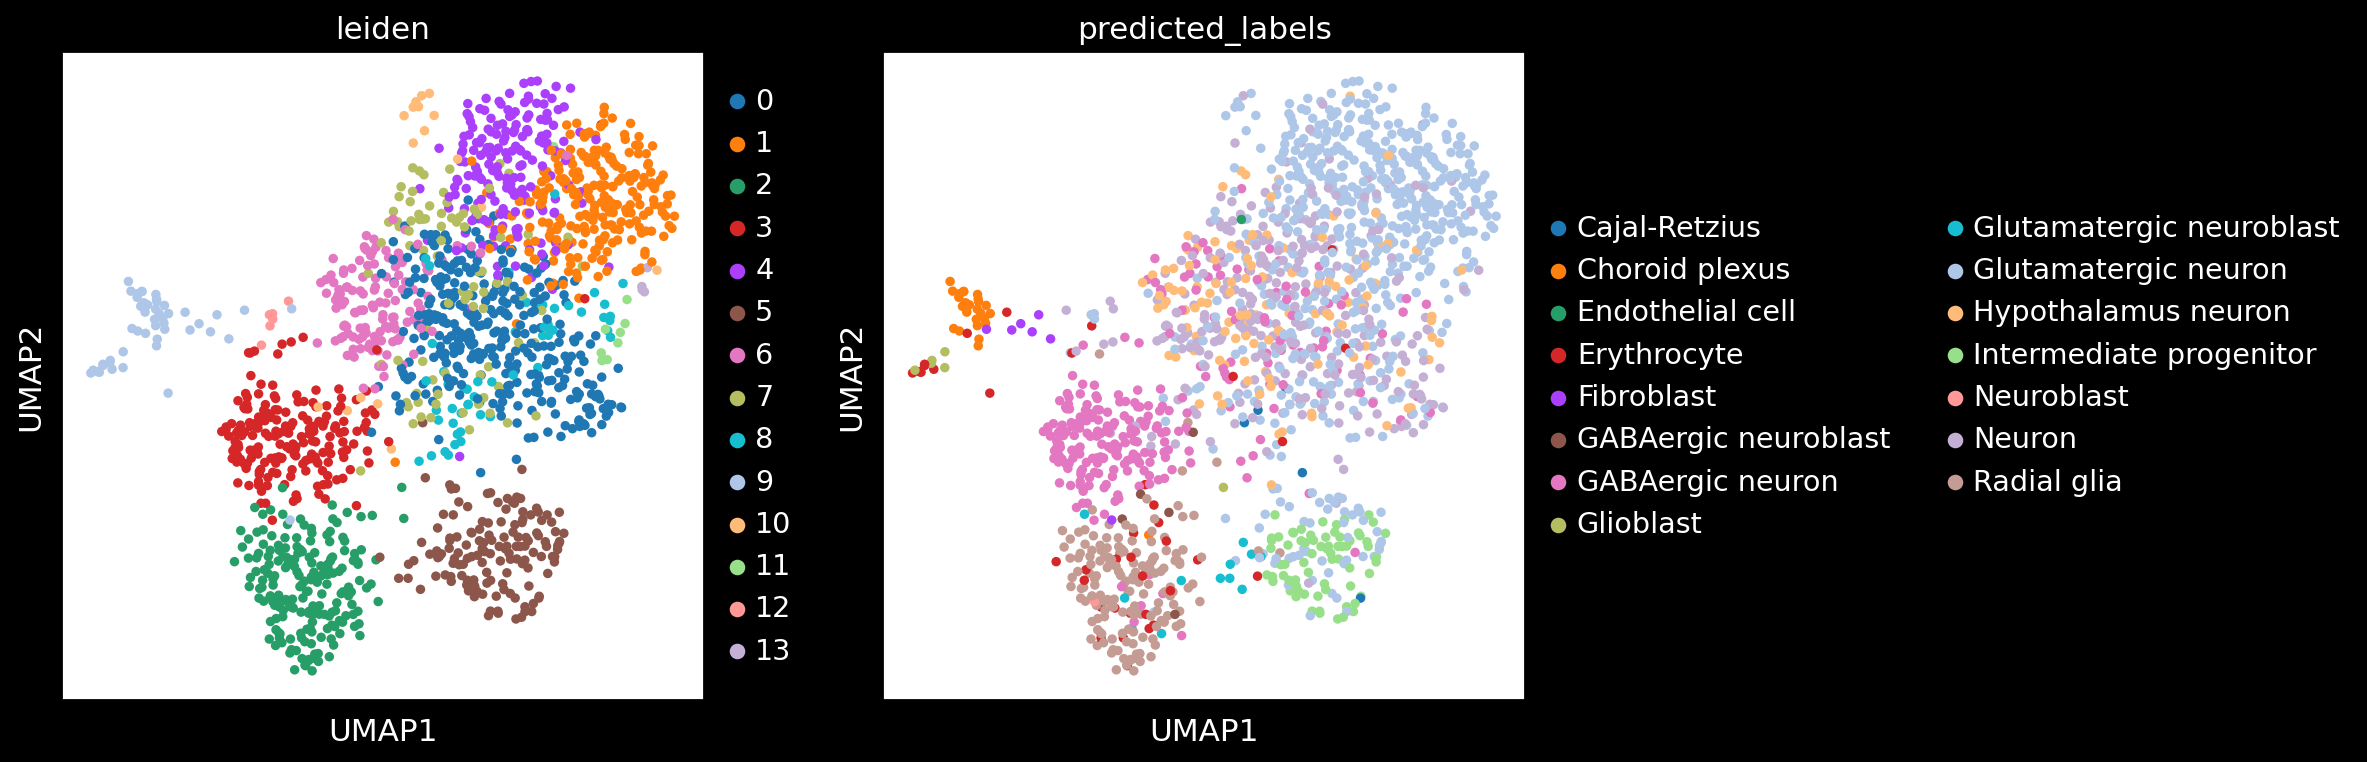

In [18]:
# plot leiden clustering and predicted labels from Bering
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
axes[0] = sc.pl.umap(adata_ensembl, color = ['leiden'], ax = axes[0], show = False)
axes[1] = sc.pl.umap(adata_ensembl, color = ['predicted_labels'], ax = axes[1], show = False)

plt.subplots_adjust(wspace = 0.5)
plt.tight_layout()
plt.show()